# MACHINE LEARNING IN GRAPH & TEXT DATA

# LINK PREDICTION IN GRAPH


## S. Calcagno, I. Koval, B. Rozière

This notebook is part of the report of the Machine Learning in graph and text data. The goal was to predict citations between articles based on their title, abstract, authors and year of publication.

The notebook is structured as follow:
- I. DATA IMPORTATION
- II. FEATURE ENGINEERING
- III. CLASSIFIER
- IV. ASSEMBLING
- V. SUBMISSION


### Comments
The code was fully optimized so that it takes less than 45 minutes to create all the features.

# I. DATA IMPORTATION

In [1]:
import random
import numpy as np
from sklearn import svm
from sklearn.metrics.pairwise import linear_kernel
from sklearn import preprocessing
import nltk
import csv
import pandas as pd
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import networkx as nx
import re
from sklearn.metrics import accuracy_score
from sknn.mlp import Layer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sknn.mlp import Classifier as MLP
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [2]:
path_to_data = "../"
info = pd.read_csv(
    path_to_data+"node_information.csv", 
    header= None, 
    names=["Id", "year", "title", "authors", "journal", "abstract"],
    sep=",",
    index_col = 0
)

In [3]:
X_train = pd.read_csv("training_set.txt", sep=" ", header=None)
X_test = pd.read_csv("testing_set.txt", sep=" ", header=None)
y_train = X_train[2]
X_train.drop([2], axis = 1, inplace = True)

# II. FEATURE ENGINEERING

This part includes :
- Feature Preprocess
- Topologic features (graph of the articles)
- Semantic features
- Attributes features 
- Topologic features (graph of the authors)

# II.1 Feature Preprocess

- list_authors is the list of authors in the papers. They are presented as follow : "Michalis Vazirgiannis, Erwan Le Pennec et al" becomes ["m. vazirgiannis", "e. pennec"]
- list_universities is the list where the authors are from

In [4]:
from authors_and_universities import authors_and_universities

list_authors, list_universities = authors_and_universities(info)
info['authors'] = list_authors
info['universities'] = list_universities

# II. 2. Topologic features

Creates a graph of the articles, then compute the following features : 
- Betweeness centrality
- Number of common neighbours
- Jaccard Coefficient
- Difference in inlinks coefficient
- Number of times "to" cites
- Same cluster

In [5]:
from create_topologic_features import make_graph, create_topologic_features

G = make_graph(X_train, y_train, X_test)  
X_train = create_topologic_features(X_train, G)
X_test = create_topologic_features(X_test, G)

# II.3. NLP features


For NLP features, we will:
### 1. Train a word 2 vec model
We concatenate the abstract and title texts as sentence inputs for training

In [7]:
from semantic_features import *


sentences = []  # Initialize an empty list of sentences
word_list_abstract=pd.Series(index=info.index,dtype=np.str)
word_list_title=pd.Series(index=info.index,dtype=np.str)

for idx in info.index:
    w_list_a = text_to_sentences(info.loc[idx,"abstract"], tokenizer, True)
    sentences += w_list_a
    word_list_abstract[idx]= w_list_a
    w_list_t = text_to_sentences(info.loc[idx,"title"], tokenizer, True)
    sentences += w_list_t
    word_list_title[idx]= w_list_t

num_features = 200
model = load_model(
    sentences, 
    train = True, 
    num_features = num_features, 
    min_word_count = 10, 
    num_workers = 4, 
    context = 10, 
    downsampling = 1e-3
)

Training model...


We use this model to transform the abstract and title into a list of word vectors and compute the centroid of those lists

In [8]:
centroid_title = dict(zip(info.index, getAvgFeatureVecs(info.title.values, model, num_features)))
centroid_abstract = dict(zip(info.index, getAvgFeatureVecs(info.abstract.values, model, num_features)))

We also use it to make word clusters.

In [9]:
# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster
word_vectors = model.syn0
num_clusters = word_vectors.shape[0] / 5

# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = num_clusters )
idx = kmeans_clustering.fit_predict( word_vectors )

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number                                                                                            
word_centroid_map = dict(zip( model.index2word, idx ))

# Pre-allocate an array for the training set bags of centroids (for speed)
bag_centroids_abstract = {}
#centroids_title = {}
# Transform the training set reviews into bags of centroids
for review, idx in zip(word_list_abstract, word_list_abstract.index):
    bag_centroids_abstract[idx] = create_bag_of_centroids(review[0], word_centroid_map)

We also compute a list of words from title and abstract to compute the Jaccard similarity.

In [10]:
w_l_title = info.title.apply(lambda x: text_to_wordlist(x, True))
w_l_abstract = info.abstract.apply(lambda x: text_to_wordlist(x, True))

We call a function that computes all these variables 

In [11]:
%%time
X_train = create_nlp_features(
    X_train, centroid_title, centroid_abstract, bag_centroids_abstract, w_l_title, w_l_abstract)
X_test = create_nlp_features(
    X_test,centroid_title, centroid_abstract, bag_centroids_abstract, w_l_title, w_l_abstract)

CPU times: user 6min 50s, sys: 1.01 s, total: 6min 51s
Wall time: 6min 51s


semantic_features.py:200: FutureWarning: scalar indexers for index type Int64Index should be integers and not floating point
  bag=[jaccard(list_of_words_dic[x[0]], list_of_words_dic[x[1]]) for x in X]


# II.4. Attribute features

- Difference in publication year
- Number of common authors
- Self-citation
- Same journal

In [12]:
%%time
from create_attribute_features import create_attribute_features
X_train = create_attribute_features(X_train,info)
X_test = create_attribute_features(X_test,info)

CPU times: user 4min 58s, sys: 1.71 s, total: 5min
Wall time: 4min 59s


# II.5. Author Graph features

- TBC: AUTHORS NORMALIZED NUMBER SAME CLUSTER
- TBC: AUTHORS SLUTER JACCARD
- Authors betweeness centrality
- Authors common neighbors
- Authors Jaccard Coefficient
- Authors max difference in inlinks
- Authors sum difference in inlins
- Authors max of times to cited
- Authors sum of times to cited
- Authors median of times to cited

In [13]:
%%time 

from author_graph import make_graph_authors, create_topologic_features_authors

G_authors = make_graph_authors(X_train, y_train, info)
X_train = create_topologic_features_authors(X_train, G_authors, info, betweeness = True, common_neigh_and_jacc = True, inlinks = True)
X_test = create_topologic_features_authors(X_test, G_authors, info,  betweeness = True, common_neigh_and_jacc = True, inlinks = True)

creating cluster features
cluster features created
creating cluster features
cluster features created
CPU times: user 11min 57s, sys: 3.81 s, total: 12min 1s
Wall time: 11min 59s


# III. CLASSIFIERS

X_train_light and X_train_light2 are created by removing some of the least efficient features from the training set. The light2 version is the best one for random forest and the light version is the best with gradient boosting. The light and original version give similar accuracy score with neural networks. 

In [19]:
X_train_light = X_train.drop([0,1,"Number of times to cited","Authors median of times to cited"], axis = 1)
X_test_light = X_test.drop([0,1,"Number of times to cited","Authors median of times to cited"], axis = 1)

In [20]:
X_train_light2 = X_train.drop([0,1,"Number common neighbours","Self citation","Same journal","Authors max difference in inlinks",
                                   "Number of times to cited","Authors median of times to cited"], axis = 1)
X_test_light2 = X_test.drop([0,1,"Number common neighbours","Self citation","Same journal","Authors max difference in inlinks",
                             "Number of times to cited","Authors median of times to cited"], axis = 1)

# III.1. Random Forest

In [24]:
%%time 
rfc = RandomForestClassifier(n_estimators = 400,n_jobs=3)
rfc.fit(X_train_light2, y_train)
pred_rfc = rfc.predict(X_test_light2)

CPU times: user 1min 29s, sys: 336 ms, total: 1min 30s
Wall time: 34.8 s


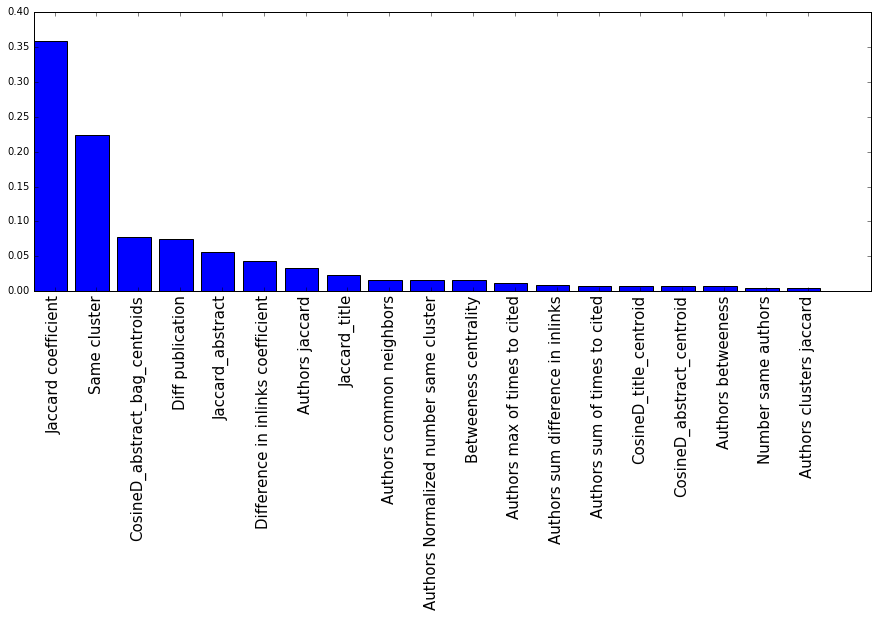

In [25]:
plt.figure(figsize=(15, 5))
X_columns = X_train_light2.columns
ordering = np.argsort(rfc.feature_importances_)[::-1]

importances = rfc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

# III.2. Neural Networks

In [26]:
scaler1=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn = MLP(
layers=[
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
    Layer("Rectifier", units=100),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=100,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = True,
        random_state = 42
        #    regularize = 'L2'
)

clfnn = Pipeline([
    ("scaler", scaler1),
    ('neural network', nn)
    ])

clfnn.fit(X_train.values, y_train.values)
pred_nn1 = clfnn.predict(X_test).flatten()

/home/bat/anaconda2/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")


In [27]:
scaler1_light=StandardScaler()
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
nn_light = MLP(
layers=[
    Layer("Rectifier", units=50),
    Layer("Rectifier", units=50),
    Layer("Rectifier", units=50),
    Layer("Rectifier", units=40),
    Layer("Rectifier", units=40),
           Layer("Softmax")],
        learning_rule = 'momentum', learning_rate=0.05, batch_size = 100,dropout_rate =0.1,
        n_iter=150,
        verbose = 1, 
        valid_size = 0.1, 
        n_stable = 25,
        debug = False,
        random_state = 43
        #    regularize = 'L2'
)

clfnn_light = Pipeline([
    ("scaler", scaler1_light),
    ('neural network', nn_light)
    ])

clfnn_light.fit(X_train_light.values, y_train.values)
pred_nn2 = clfnn_light.predict(X_test_light).flatten()

# III.3. Gradient Boosting

In [28]:
gbc = GradientBoostingClassifier(n_estimators = 400, max_depth = 7)
gbc.fit(X_train_light, y_train)
pred_gbc = gbc.predict(X_test_light)

# IV. ASSEMBLING

In [29]:
#rounds a whole list or array of integers between 0 and 1 to transform a probability into a prediction
def rounds(predict):
    return [0 if pr<=0.5 else 1 for pr in predict]

#makes a prediction based on an array of probabilities to have 1 and weights. It computes the average probability and rounds it
def make_pred(y_pred_array, weights = None):
    if weights ==None:
        weights = [1 for i in y_pred_array]
    return np.array(rounds(1./sum(weights)*sum([weights[i]*y for i,y in enumerate(y_pred_array)])))

In [30]:
y_pred_array = [pred_gbc, pred_rfc, pred_nn1, pred_nn2]

In [31]:
pred= make_pred(y_pred_array, [1,1,1,1])

# V. SUBMISSION

In [38]:
#simply computes a dataframe containing the submit and creates a file (submit.csv by default) that can be submitted on kaggle
def make_submission(predicted_label, name = 'submit.csv'):
    submit_d = d = {'id' : pd.Series(np.arange(1,X_test.shape[0]+1).astype(int)),
                    'category' : pd.Series(predicted_label).astype(int)}
    submit = pd.DataFrame(submit_d, columns=["id","category"])
    submit.to_csv(name,index=False)
    return submit

In [39]:
submit = make_submission(pred)

In [40]:
submit["category"]

0        1
1        1
2        1
3        1
4        1
5        0
6        0
7        1
8        0
9        1
10       1
11       1
12       1
13       1
14       1
15       0
16       0
17       1
18       1
19       1
20       1
21       0
22       1
23       1
24       0
25       0
26       1
27       1
28       0
29       0
        ..
32618    0
32619    1
32620    1
32621    0
32622    1
32623    0
32624    0
32625    0
32626    1
32627    0
32628    1
32629    0
32630    0
32631    1
32632    1
32633    0
32634    0
32635    1
32636    1
32637    0
32638    0
32639    0
32640    0
32641    0
32642    0
32643    1
32644    0
32645    0
32646    0
32647    1
Name: category, dtype: int64